# Homework 3


## APMTH 207:  Stochastic Methods for Data Analysis, Inference and Optimization

**Due Date: ** Thursday, Febrary 16th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [1]:
%matplotlib inline
import theano
from theano import *
import theano.tensor as T
import pandas as pd
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from numpy import linalg 

## Problem 1: Optimization via Descent

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by

$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$

Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Part A
- Visually verify that for $\lambda_1 = 2.05384, \lambda_2 = 0$, the loss function $L$ is minimized for the given data.
- Implement gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.
- Implement stochastic gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.

### Part B
- Compare the average time it takes to update the parameter estimation in each iteration of the two implementations. Which method is faster? Briefly explain why this result should be expected.
- Compare the number of iterations it takes for each algorithm to obtain an estimate accurate to `1e-3` (you may wish to set a cap for maximum number of iterations). Which method converges to the optimal point in fewer iterations? Briefly explain why this result should be expected.

### Part C
Compare the performance of stochastic gradient descent for the following learning rates: 1, 0.1, 0.001, 0.0001. Based on your observations, briefly describe the effect of the choice of learning rate on the performance of the algorithm.

# Solutions to Part A

# Part A.a

$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$


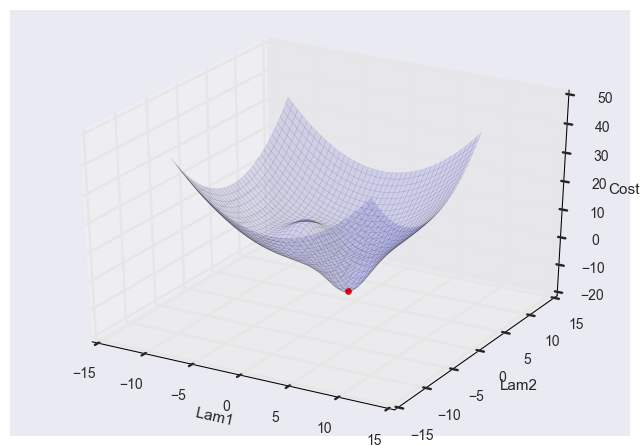

In [2]:
from mpl_toolkits.mplot3d import Axes3D
data = pd.read_csv('HW3_data.csv',header=None)
#print (data.shape)
data.T.shape
df = pd.DataFrame(data)
data_x = df.T[0]
data_y = df.T[1]
x = T.vector('x')
y = T.vector('y')
l1 = T.dscalar('l1')
l2 = T.dscalar('l2')
lambda1 =2.05384

lambda2 = 0
cost = 0.000045*l2**2*y - 0.000098*l1**2*x + 0.003926*l1*x*np.exp((y**2-x**2)*(l1**2+l2**2))
#print (np.sum(cost))
f = function([x,y,l1,l2],cost)

m = f(data_x,data_y,lambda1,lambda2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
la1 = np.arange(-10,10,0.05)
la2 = np.arange(-10,10,0.05)
X, Y = np.meshgrid(la1, la2)
#X, Y = np.meshgrid(data_x, data_y)
#print ()
zs = np.array([np.sum(f(data_x,data_y,x,y)) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)
ax.plot_surface(X,Y, Z,alpha = 0.1)


xcod = [lambda1]
ycod = [lambda2]
zcod = [np.sum(f(data_x,data_y,lambda1,lambda2))]

sc = ax.scatter(xcod,ycod,zcod,color ='r')
#ax.plot_surface(X, Y, Z,alpha = 0.1)

ax.set_xlabel('Lam1 ')
ax.set_ylabel('Lam2')
ax.set_zlabel('Cost')
plt.show()


# Part A.b Gradient Descent  
### I list two stopping criteria for Gradient_Decent:

#### Here is the only difference between them:

- #### Gradient_Decent: the programme stops when lambda 1 and lambda 2 are close to desired (TRUE) lambda 1 and lamba2 
(if (np.linalg.norm(np.array([lam1, lam2]) - np.array([2.05384, 0])) < threshold):)


- #### Gradient_Decent1: the programme stops when the current average cost is close too the previous one
（$ \text{d = abs(cost1 - cost2)}$     $\text{ if (d < threshold):}$）

### The first criterion is more like simulation and the second looks more practical ！！！


In [27]:
def Gradient_Decent(ini_l1,ini_l2,threshold,data_x,data_y,eta):
    start_time = time.time()
    #lam1 = theano.shared(2+np.random.randn(),name='lam1',borrow=True)
    #lam2 = theano.shared(np.random.randn(),name='lam2',borrow=True)
    lam1 = theano.shared(ini_l1,name='lam1',borrow=True)
    lam2 = theano.shared(ini_l2,name='lam2',borrow=True)
    #print(lam1)
    print("Initial model:")
    print('Lambda1:',lam1.get_value())
    print('Lambda2:',lam2.get_value())

    #cost = T.sum(0.000045*lam2**2*data_y - 0.000098*lam1**2*data_x + 0.003926*lam1*data_x*T.exp((data_y**2-data_x**2)*(lam1**2+lam2**2)))


    cost = 1000 * T.sum(0.000045*lam2**2*y - 0.000098*lam1**2*x + 0.003926*lam1* x * T.exp((-0.1)*(lam1**2+lam2**2)))*1000/len(data_x)



    glam1 = T.grad(cost=cost, wrt=lam1)
    glam2 = T.grad(cost=cost, wrt=lam2)                   # Compute the gradient of the cost

    # Compile. What is a good learning rate?
    #eta = 0.001 # Learning rate
    train = theano.function(
              inputs=[x,y],
              outputs = [cost,lam1,lam2,glam1],
              updates=((lam1, lam1 - eta * glam1), (lam2, lam2 - eta * glam2)),name='train')

    n_epochs = 50000
    ite = 0
    maxsteps = 40000
    #print (glam1)
    for i in range(n_epochs):
        cost, lam1, lam2,glam1 = train(data_x, data_y)
        #print (cost1)
        #cost2, lam1, lam2 = train(data_x, data_y)
        ite = ite + 1
        #d = abs(cost1 - cost2)
        if (np.linalg.norm(np.array([lam1, lam2]) - np.array([2.05384, 0])) < threshold):
        #if (d < threshold):

            print ('Iterations:',ite)
            print ('lambda1 is:',lam1)
            print ('Lambda2 is:',lam2)
            break

               
        if maxsteps:
            if (ite == maxsteps):
                print("maxsteps:",maxsteps)
                break


    print("run time: %s seconds " % (time.time() - start_time))
    print ('Average time for gd: %s seconds'% ((time.time() - start_time)/ite))

In [28]:
def Gradient_Decent1(ini_l1,ini_l2,threshold,data_x,data_y,eta):
    start_time = time.time()
    #lam1 = theano.shared(2+np.random.randn(),name='lam1',borrow=True)
    #lam2 = theano.shared(np.random.randn(),name='lam2',borrow=True)
    lam1 = theano.shared(ini_l1,name='lam1',borrow=True)
    lam2 = theano.shared(ini_l2,name='lam2',borrow=True)
    #print(lam1)
    print("Initial model:")
    print('Lambda1:',lam1.get_value())
    print('Lambda2:',lam2.get_value())

    #cost = T.sum(0.000045*lam2**2*data_y - 0.000098*lam1**2*data_x + 0.003926*lam1*data_x*T.exp((data_y**2-data_x**2)*(lam1**2+lam2**2)))


    cost = 1000 * T.sum(0.000045*lam2**2*y - 0.000098*lam1**2*x + 0.003926*lam1* x * T.exp((-0.1)*(lam1**2+lam2**2)))*1000/len(data_x)



    glam1 = T.grad(cost=cost, wrt=lam1)
    glam2 = T.grad(cost=cost, wrt=lam2)                   # Compute the gradient of the cost

    # Compile. What is a good learning rate?
    #eta = 0.001 # Learning rate
    train = theano.function(
              inputs=[x,y],
              outputs = [cost,lam1,lam2,glam1],
              updates=((lam1, lam1 - eta * glam1), (lam2, lam2 - eta * glam2)),name='train')

    n_epochs = 50000
    ite = 0
    maxsteps  = 40000
    #print (glam1)
    for i in range(n_epochs):
        #cost, lam1, lam2,glam1 = train(data_x, data_y)
        #print (cost1)
        cost1, lam1, lam2,glam1 = train(data_x, data_y)
        cost2, lam1, lam2,glam2 = train(data_x, data_y)
        ite = ite + 1
        d = abs(cost1 - cost2)
        #if (np.linalg.norm(np.array([lam1, lam2]) - np.array([2.05384, 0])) < threshold):
        if (d < threshold):

            print ('Iterations:',ite)
            print ('lambda1 is:',lam1)
            print ('Lambda2 is:',lam2)
            break
        
                   
        if maxsteps:
            if (ite == maxsteps):
                print("maxsteps:",maxsteps)
                break




    print("run time: %s seconds " % (time.time() - start_time))
    print ('Average time for gd: %s seconds' %((time.time() - start_time)/ite))    

### Solution using Gradient_Decent: (Stopping Criterion 1) :

#### The programme stops when lambda 1 and lambda 2 are close to desired (TRUE) lambda 1 and lamba2 


(if (np.linalg.norm(np.array([lam1, lam2]) - np.array([2.05384, 0])) < threshold):)

In [46]:
threshold = 1e-5
lam1 = 2.10
lam2 = 0.00
eta = 0.001
Gradient_Decent(lam1,lam2,threshold,data_x,data_y,eta)


Initial model:
Lambda1: 2.1
Lambda2: 0.0
Iterations: 30
lambda1 is: 2.0538497658230823
Lambda2 is: 0.0
run time: 0.35582399368286133 seconds 
Average time for gd: 0.011861101786295573 seconds


### Solution using Gradient_Decent1 (Stopping Criterion 2) :

#### The programme stops when the current average cost is close too the previous one
$ \text{d = abs(cost1 - cost2)}$     $\text{ if (d < threshold):}$




In [47]:
threshold = 1e-5
lam1 = 2.10
lam2 = 0.00
eta = 0.001
Gradient_Decent1(lam1,lam2,threshold,data_x,data_y,eta)



Initial model:
Lambda1: 2.1
Lambda2: 0.0
Iterations: 8
lambda1 is: 2.0540073183805987
Lambda2 is: 0.0
run time: 0.3091719150543213 seconds 
Average time for gd: 0.03864750266075134 seconds


## Summary to Part A.b
#### There is a tradeoff between precision and run time, higher precision we want, longer time we need.

Based on the two stopping critera, we find that if we want our real values (lambda1,lambda2) to be close to TRUE values, the programme will run for much longer time than using stopping criterion 2 when we just want the cost difference to be close.


# Stochastic Gradient Descent

# Part A.c Stochatic Gradient Descent  
### I also list two stopping criteria for Stochatic_Gradient_Decent:

#### Here is the only difference between them:

- #### stochastic_gradient: the programme stops when lambda 1 and lambda 2 are close to desired (TRUE) lambda 1 and lamba2 
(if (np.linalg.norm(np.array([lam1, lam2]) - np.array([2.05384, 0])) < threshold):)


- #### stochastic_gradient1: the programme stops when the current average cost is close too the previous one
（d = abs(cost1 - cost2)if (d < threshold):）

### The first criterion is more like simulation and the second looks more practical ！！！

In [44]:
def stochastic_gradient(ini_l1,ini_l2,threshold,data_x,data_y,eta):
    import time
    start_time = time.time()
    
    #lam1 = theano.shared(2+np.random.randn(),name='lam1',borrow=True)
    #lam2 = theano.shared(np.random.randn(),name='lam2',borrow=True)
    lam1 = theano.shared(ini_l1,name='lam1',borrow=True)
    lam2 = theano.shared(ini_l2,name='lam2',borrow=True)
    #print(lam1)
    print("Initial model:")
    print(lam1.get_value())
    print(lam2.get_value())

    x1 = T.dscalar('x1')
    y1 = T.dscalar('y1')
    cost = (0.000045*lam2**2*y1 - 0.000098*lam1**2*x1 + 0.003926*lam1* x1 * T.exp((-0.1)*(lam1**2+lam2**2))) * 1000
    glam1 = T.grad(cost=cost, wrt=lam1)
    glam2 = T.grad(cost=cost, wrt=lam2)                   # Compute the gradient of the cost

    # Compile. What is a good learning rate?
    #eta = 0.001 # Learning rate

    train1 = theano.function(
              inputs=[x1,y1],
              outputs = [cost,lam1,lam2],
              updates=((lam1, lam1 - eta * glam1), (lam2, lam2 - eta * glam2)),name='train')


    n_epochs = 1000000
    ite = 0
    s = 0
  #  print (data_x[s])
    costlist1 = list()
    costlist2 = list()
    counter = 0
    c = 0
    #history
    maxsteps = 20000
    #for i in range(n_epochs):
    for i in range(n_epochs):
        counter  = counter + 1
        cost1, lam1, lam2 = train1(data_x[s], data_y[s])
        cost2, lam1, lam2 = train1(data_x[s], data_y[s])
        
        costlist1.append(cost1)
        costlist2.append(cost2)
        costsum1 = T.mean(costlist1)*1000
        costsum2 = T.mean(costlist2)*1000
        
        #print (costsum1)
        #print (costsum2)
        s = s + 1
        # print (lam1)
        if (s == len(data_x)):
            neworder = np.random.permutation(len(data_x))
            data_x = data_x[neworder]
            data_y = data_y[neworder] 
            s = 0
        ite = ite + 1
        #d = abs(cost1 - cost2)
        #print (np.linalg.norm(np.array([lam1, lam2])))
        p = np.linalg.norm(np.array([lam1, lam2]) - np.array([2.05384, 0]))
        # print (p)
        if (p < threshold):
            print ('Iterations:',ite)
            print ('lambda1 is:',lam1)
            print ('Lambda2 is:',lam2)
            break
        if (maxsteps):
            if (ite == maxsteps):
                print("maxsteps:",maxsteps)
                break


    #plt.plot([t for t in history1], [t for t in history2],'o-', alpha=0.1)   
    print("run time: %s seconds " % (time.time() - start_time))
    print ('Average time for sgd: %s seconds'%((time.time() - start_time)/ite))
    #return history1,history2

In [22]:
def stochastic_gradient1(ini_l1,ini_l2,threshold,data_x,data_y,eta):
    import time
    start_time = time.time()
    
    #lam1 = theano.shared(2+np.random.randn(),name='lam1',borrow=True)
    #lam2 = theano.shared(np.random.randn(),name='lam2',borrow=True)
    lam1 = theano.shared(ini_l1,name='lam1',borrow=True)
    lam2 = theano.shared(ini_l2,name='lam2',borrow=True)
    #print(lam1)
    print("Initial model:")
    print(lam1.get_value())
    print(lam2.get_value())

    x1 = T.dscalar('x1')
    y1 = T.dscalar('y1')
    cost = (0.000045*lam2**2*y1 - 0.000098*lam1**2*x1 + 0.003926*lam1* x1 * T.exp((-0.1)*(lam1**2+lam2**2))) * 1000
    glam1 = T.grad(cost=cost, wrt=lam1)
    glam2 = T.grad(cost=cost, wrt=lam2)                   # Compute the gradient of the cost

    # Compile. What is a good learning rate?
    #eta = 0.001 # Learning rate

    train1 = theano.function(
              inputs=[x1,y1],
              outputs = [cost,lam1,lam2],
              updates=((lam1, lam1 - eta * glam1), (lam2, lam2 - eta * glam2)),name='train')


    n_epochs = 500000
    ite = 0
    s = 0
  #  print (data_x[s])
    costlist1 = list()
    costlist2 = list()
    counter = 0
    c = 0
    history1 = list()
    history2 = list()
    maxsteps = 400000
    for i in range(n_epochs):
        counter  = counter + 1
        cost1, lam1, lam2 = train1(data_x[s], data_y[s])
        cost2, lam1, lam2 = train1(data_x[s], data_y[s])
        
        costlist1.append(cost1)
        costlist2.append(cost2)
        costsum1 = T.mean(costlist1)*10000
        costsum2 = T.mean(costlist2)*10000
        history1.append(lam1)
        history2.append(lam2)
        #print (lam1)
        #print (costsum2)
        s = s + 1
        #print ('ll,l2',lam1,lam2)
        if (s == len(data_x)):
            neworder = np.random.permutation(len(data_x))
            data_x = data_x[neworder]
            data_y = data_y[neworder] 
            s = 0

        ite = ite + 1
        d = abs(cost1 - cost2)
        #print (d)
        if (d < threshold):

            print ('Iterations:',ite)
            print ('lambda1 is:',lam1)
            print ('Lambda2 is:',lam2)
            break
        if maxsteps:
            if (ite == maxsteps):
                print("maxsteps:",maxsteps)
                break
    
    print("run time: %s seconds " % (time.time() - start_time))
    print ('Average time for sgd: %s seconds'%((time.time() - start_time)/ite))


  #  return history1,history2

### Solution using Stochatic_Gradient_Decent: (Stopping Criterion 1) :

#### The programme stops when lambda 1 and lambda 2 are close to desired (TRUE) lambda 1 and lamba2 


(if (np.linalg.norm(np.array([lam1, lam2]) - np.array([2.05384, 0])) < threshold):)



In [26]:

threshold = 1e-5

lam1 = 2.1
lam2 = 0.000
eta = 0.001
stochastic_gradient(lam1,lam2,threshold,data_x,data_y,eta)



Initial model:
2.1
0.0
Iterations: 15895
lambda1 is: 2.053849960720497
Lambda2 is: 0.0
run time: 146.39844703674316 seconds 
Average time for sgd: 0.0092103464643173 seconds


### Solution using Stochatic_Gradient_Decent1 (Stopping Criterion 2) :

#### The programme stops when the current average cost is close too the previous one
$ \text{d = abs(cost1 - cost2)}$     $\text{ if (d < threshold):}$



In [24]:

threshold = 1e-5

lam1 = 2.1
lam2 = 0.000
eta = 0.001
stochastic_gradient1(lam1,lam2,threshold,data_x,data_y,eta)




Initial model:
2.1
0.0
Iterations: 15870
lambda1 is: 2.0550539109826533
Lambda2 is: 0.0
run time: 164.3706340789795 seconds 
Average time for sgd: 0.010357318408247353 seconds


# Solutions to Part B:

# Part B.a

In [48]:
print ('Result using Gradient decent method')
threshold = 1e-3
lam1 = 2.10
lam2 = 0.00
eta = 0.001
Gradient_Decent(lam1,lam2,threshold,data_x,data_y,eta)




threshold = 1e-3
lam1 = 2.100
lam2 = 0.00
eta = 0.001

print ('\nResult using Stochastic gradient method')
stochastic_gradient(lam1,lam2,threshold,data_x,data_y,eta)


Result using Gradient decent method
Initial model:
Lambda1: 2.1
Lambda2: 0.0
Iterations: 12
lambda1 is: 2.054569886970706
Lambda2 is: 0.0
run time: 0.3169829845428467 seconds 
Average time for gd: 0.026416003704071045 seconds

Result using Stochastic gradient method
Initial model:
2.1
0.0
Iterations: 15872
lambda1 is: 2.0545395940264863
Lambda2 is: 0.0
run time: 170.15149784088135 seconds 
Average time for sgd: 0.010720231089620821 seconds


## Discussion:

Comparing the average time using gradient decent method ($0.0264 $ seconds) with stochastic gradient method ( $ 0.011  $ seconds), it can be found that the stochastic gradient method run relatively fast for each interation.

The gradient descent algorithm always proceeds in the direction of steepest descent (the gradient of $J$) and guarantees that we find a local minimum (global under certain assumptions on $J$). When we have very large data sets, however, the calculation of $\nabla (J(\theta))$ can be costly as we must process every data point before making a single step. 

An alternative approach, the stochastic gradient descent method, is to update $\theta$ sequentially with every observation, leading to a relatively less cost compared with gradient decent method.

# Part B.b
## Discussion:
The number of iterations using gradient method is 12, however, the number using stochastic gradient method is 15872, which is much larger than the steps when using gradient decent method. So gradient decent can converge to the optimal point in fewer iterations. The main difference between the two method is from the calculation of gradient of cost function.

For gradient method, we take all the data set values into consideration, which can make the direction of each interatin more resonable and stable by accumulating all the costs for each step. 

On the other hand, the stochastic gradient method only considers one sigle data point when calculating the cost for each iteration. Therefore, the decent direction can be flutuated depending on each data point and less stable than the decent direction when applying gradient decent method, which make it very hard to be close to true minimum value. 

To conclude, although the stochastic gradient descent method is useful when we want a quick and dirty approximation for the solution to our optimization problem, compared with gradient decent, it could not easily be close to true value precisely. On the other hand, gradient decent can be used to calulate the optimal value, but it may not as efficient as stochastic gradient method when dealing with large dataset, since it takes much time to consider accumulated costs.

# Part C:

Compare the performance of stochastic gradient descent for the following learning rates: 1, 0.1, 0.001, 0.0001. Based on your observations, briefly describe the effect of the choice of learning rate on the performance of the algorithm.

In [45]:
lam1 = 2.100
lam2 = 0.00
threshold1 = 1e-2
print('learning rate = 1')
eta = 1
stochastic_gradient(lam1,lam2,threshold1,data_x,data_y,eta)

print('\nlearning rate = 0.1')
eta = 0.1
stochastic_gradient(lam1,lam2,threshold1,data_x,data_y,eta)

print('\nlearning rate = 0.001')
eta = 0.001
stochastic_gradient(lam1,lam2,threshold1,data_x,data_y,eta)

print('\nlearning rate = 0.0001')
eta = 0.0001
stochastic_gradient(lam1,lam2,threshold1,data_x,data_y,eta)




learning rate = 1
Initial model:
2.1
0.0
maxsteps: 20000
run time: 255.7084047794342 seconds 
Average time for sgd: 0.012785420894622803 seconds

learning rate = 0.1
Initial model:
2.1
0.0
maxsteps: 20000
run time: 264.6325840950012 seconds 
Average time for sgd: 0.01323162989616394 seconds

learning rate = 0.001
Initial model:
2.1
0.0
Iterations: 15864
lambda1 is: 2.061658134425235
Lambda2 is: 0.0
run time: 153.68758296966553 seconds 
Average time for sgd: 0.009687821040295376 seconds

learning rate = 0.0001
Initial model:
2.1
0.0
maxsteps: 20000
run time: 238.11207795143127 seconds 
Average time for sgd: 0.011905604553222657 seconds


## Discussion
When we set the step length to be large, such as 1 and 0.1, stochastic gradient method could not get to the optimal point within 20000 steps. On the other hand, if we set the step length to be smaller, sgd could also not reach the optimal point with finte steps. The best step length in this case is 0.001(median  among the four different length settings). According to the results, it can be found that the performance of sgd highly depends on the setting of step length. When the length is too large, the point for each iteration jumps too often and could not be stable and converge to optimal point. When the length is too small, each step only change a small value and it will take a very long time to be close to the optimal value. Therefore, picking a appropriate step length is very important when implementing sgd. 